### Introduction


Illegal fishing activities pose a significant threat to marine biodiversity, undermining the sustainability of global fish stocks and affecting the livelihoods of communities dependent on fishing. This project leverages data science and machine learning techniques to unravel patterns of illegal fishing by analyzing transshipment and loitering events, as well as vessel encounters. Through exploratory data analysis, we aim to uncover the primary actors in illegal fishing, identify hotspots of such activities, and understand the spatial and temporal dynamics of these vessels. Furthermore, machine learning models will be employed to predict future encounters and assess the probability of vessels operating within Exclusive Economic Zones (EEZs) illegally. This study not only seeks to enhance our understanding of illegal fishing activities but also provides insights that could inform enforcement and policy-making efforts.


#### Questions we will attempt to answer from Exploritory Data Analysis:
- What countries are the biggest culprits in the illegal fisshing trade
- Approximately how many transshipment vessels are taking part in the illegal fisshing trade
- What, if any, are the spatial and temporal relationships between ttransshipment vessels
- What are the hotspots around the world where we can expect to find these transshipment vessels
- Are there times that vessels are within other country's maritime boundries?
- Can we predict any future encounters between any fishing vessels and transshipment vessels?
#### Questions we will attempt to answer from Machine Learning:
- Can we predict if vessels will be within a country's maritime boundry and where
- Can we forcast vessel movements
- Can we identify/track vessel names

### Project Outline Map

1. Data Exploration
- 1.1 Data Description
- 1.2 Load Data
- 1.3 View Data

2. Exploratory Data Analysis
- 2.1 Data Cleaning
- 2.2 Merge Dataframes
- 2.3 Adding Columns

3. Target Variable Analysis
- 3.1 What countries are most represented in the DataFrames
- 3.2 Unique Vessels in our Dataframes

4. Statistical Analysis
- 4.1 Statistical Analysis for Anomaly Detection
- 4.2 Predict Future Associations Between Vessels

5. Machine Leaning Analysis
- 5.1 Predict If A Vessel Will Be Located Within A Country's Maritime Boundry (EEZ)
- 5.2 Time Series Analysis And Forecast Vessel Movements Using LSTM
- 5.3 Natural Language Processing (NLP) on Ship Names

6. Visualizations
- 6.1 Temporal Relationships
- 6.2 Spatial Relationship - Community Connections
- 6.3 Global Vessel Locations with Loitering Vessels and Vessel Encounters
- 6.4 Global Vessels and Position Relative to Countries Maritime Boundries
- 6.5 Heat Map of Vessels within Country's Maritime Boundries

7. Final Analysis

8. Further Research

9. References and Rescources

In [1]:
# Base Libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import folium
from folium.plugins import HeatMap
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point


# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Statistics
import networkx as nx
from itertools import combinations
import community as community_louvain
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
from math import sqrt


# Misc
import warnings
warnings.filterwarnings("ignore")

## 1. Data Exploration

### 1.1 Data Description

#### Transshipment Vessel Table Schema
transshipment-vessels-v20170717.csv
- `mmsi`: MMSI
- `shipname`: Normalized shipname
- `callsign`: Normalized callsign
- `flag`: Flag state ISO3 alpha code
- `imo`: IMO number
- `first_timestamp`: Timestamp of the MMSI's first known AIS position
- `last_timestamp`: Timestamp fo the MMSI's last known AIS position

#### Loitering Vessel Table Schema
loitering-events-v20170717.csv
- `transshipment_mmsi`: MMSI of transshipment vessel
- `starting_latitude`: Latitude of the loitering event's first position
- `starting_longitude`: Longitude of the loitering event's first position
- `ending_latitude`: Latitude of the loitering event's last position
- `ending_longitude`: Longitude of the loitering event's last position
- `starting_timestamp`: Timestamp of the loitering event's first position
- `ending_timestamp`: Timestamp of the loitering event's last position
- `median_speed_knots`: Median speed (knots) of the transshipment vessel during the loitering event
- `total_event_duration`: Total duration (hours) of the loitering event

#### Encounter Vessel Table Schema
encounter-events-v20170717.csv
- `fishing_vessel_mmsi`: MMSI of the fishing vessel
- `transshipment_vessel_mmsi`: MMSI of the transshipment vessel
- `start_time`: Timestamp of the encounter's first position
- `end_time`: Timestamp of the encounters's last position
- `mean_latitude`: Mean latitude of the encounter event
- `mean_longitude`: Mean longitude of the encounter event
- `duration_hr`: Duration (hours) of the encounter event
- `median_distance_km`: Median distance (km) between the transshipment vessel and fishing vessel during the encounter event
- `median_speed_knots`: Median speed (knots) of the transshipment vessel during the encounter event

### 1.2 Load Data

In [2]:
# Load in the CSV files
transshipment = pd.read_csv('/Users/adamrivardwalter/Data for Processing/Preprocessing/Fisheries Project/Global Patterns of Transshipment Behavior/transshipment-vessels-v20170717.csv')
loitering = pd.read_csv('/Users/adamrivardwalter/Data for Processing/Preprocessing/Fisheries Project/Global Patterns of Transshipment Behavior/loitering-events-v20170717.csv')
encounter = pd.read_csv('/Users/adamrivardwalter/Data for Processing/Preprocessing/Fisheries Project/Global Patterns of Transshipment Behavior/encounter-events-v20170717.csv')

### 1.3 View Data

In [3]:
transshipment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mmsi             1070 non-null   float64
 1   shipname         1123 non-null   object 
 2   callsign         1106 non-null   object 
 3   flag             1124 non-null   object 
 4   imo              1074 non-null   float64
 5   first_timestamp  1070 non-null   object 
 6   last_timestamp   1070 non-null   object 
dtypes: float64(2), object(5)
memory usage: 61.6+ KB


In [4]:
transshipment.head()

,mmsi,shipname,callsign,flag,imo,first_timestamp,last_timestamp
0,306117000.0,SIERRALAUREL,PJBQ,ANT,9163403.0,2018-03-29T08:34:21Z,2018-06-30T17:08:41Z
1,306873000.0,SIERRALEYRE,PJJZ,ANT,9135822.0,2012-01-01T01:06:00Z,2012-06-26T08:58:28Z
2,309681.0,GREENBRAZIL,C6WH6,BHS,9045792.0,2018-06-29T10:34:00Z,2018-06-30T23:47:40Z
3,308735000.0,NOVA BRETAGNE,C6JI7,BHS,9000364.0,2012-01-01T00:39:08Z,2013-09-12T10:03:48Z
4,311000682.0,SIERRA LARA,C6DI3,BHS,9120205.0,2017-07-03T10:28:05Z,2018-06-30T23:35:36Z


In [5]:
loitering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46569 entries, 0 to 46568
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transshipment_mmsi    46569 non-null  int64  
 1   starting_latitude     46569 non-null  float64
 2   starting_longitude    46569 non-null  float64
 3   ending_latitude       46569 non-null  float64
 4   ending_longitude      46569 non-null  float64
 5   starting_timestamp    46569 non-null  object 
 6   ending_timestamp      46569 non-null  object 
 7   median_speed_knots    46569 non-null  float64
 8   total_event_duration  46569 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.2+ MB


In [6]:
loitering.head()

,transshipment_mmsi,starting_latitude,starting_longitude,ending_latitude,ending_longitude,starting_timestamp,ending_timestamp,median_speed_knots,total_event_duration
0,256064000,12.793800,-69.503235,12.727950,-69.739120,2017-09-06T02:11:32Z,2017-09-06T15:44:15Z,1.091065,13.915556
1,256064000,25.405013,-56.302800,25.393350,-56.488250,2017-07-22T13:19:49Z,2017-07-22T23:59:17Z,1.548335,10.897639
2,256064000,10.693413,-78.512800,10.484500,-78.884300,2017-11-29T14:48:51Z,2017-11-30T07:43:36Z,1.503456,18.001389
3,256064000,11.858933,-75.553383,12.007627,-75.535627,2017-09-07T23:39:03Z,2017-09-08T14:59:26Z,0.650355,16.193611
4,256064000,45.938747,-23.796960,45.976960,-23.449387,2017-08-17T23:18:21Z,2017-08-18T17:56:30Z,1.009874,19.748333


In [7]:
encounter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11681 entries, 0 to 11680
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fishing_vessel_mmsi        11681 non-null  int64  
 1   transshipment_vessel_mmsi  11681 non-null  int64  
 2   start_time                 11681 non-null  object 
 3   end_time                   11681 non-null  object 
 4   mean_latitude              11681 non-null  float64
 5   mean_longitude             11681 non-null  float64
 6   duration_hr                11681 non-null  float64
 7   median_distance_km         11681 non-null  float64
 8   median_speed_knots         11681 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 821.4+ KB


In [8]:
encounter.head()

,fishing_vessel_mmsi,transshipment_vessel_mmsi,start_time,end_time,mean_latitude,mean_longitude,duration_hr,median_distance_km,median_speed_knots
0,416565000,354240000,2016-11-18T14:30:00Z,2016-11-19T01:50:00Z,-17.039085,-79.063725,11.333333,0.038188,0.585402
1,412679190,354240000,2016-12-11T14:50:00Z,2016-12-11T19:50:00Z,-20.269608,-79.244953,5.000000,0.020033,0.575663
2,440863000,354240000,2017-06-13T12:50:00Z,2017-06-15T01:20:00Z,-62.640767,-60.690240,36.500000,0.054992,0.019775
3,416563000,354240000,2016-11-15T11:30:00Z,2016-11-16T04:00:00Z,-17.046586,-79.061923,16.500000,0.036427,1.023917
4,441309000,354240000,2017-05-19T00:40:00Z,2017-05-19T20:50:00Z,-46.627878,-60.554922,20.166667,0.034053,0.544031


## 2. Exploratory Data Analysis

### 2.1 Data Cleaning

In [9]:
# Fill NaN with a placeholder (-1) 
transshipment['mmsi'] = transshipment['mmsi'].fillna(-1).astype(int)

# convert 'mmsi' to int
transshipment['mmsi'] = transshipment['mmsi'].astype(int)

### 2.2 Merge Dataframes

In [10]:
# Merging transshipments to loitering vessels

# the mmsi is matched but not the event/date

# Left merge the DataFrames
merged_loitering_and_transshipment = pd.merge(left=loitering, 
                                            right=transshipment, 
                                            left_on='transshipment_mmsi', 
                                            right_on='mmsi', 
                                            how='left')  

# Percentage that merged successfully
merged_transshipment_encounter= merged_loitering_and_transshipment['mmsi'].notnull().sum()
total_loitering = len(loitering)
percentage_merged = (merged_transshipment_encounter / total_loitering) * 100

print(f"Percentage of transshipment and loitering merged: {percentage_merged:.2f}%")

Percentage of transshipment and loitering merged: 91.67%


In [11]:
# Merging transshipments to encounter vessels

# the mmsi is matched but not the event/date

# Left merge the DataFrames
merged_encounter_and_transshipment = pd.merge(left=encounter, 
                                            right=transshipment, 
                                            left_on='transshipment_vessel_mmsi', 
                                            right_on='mmsi', 
                                            how='left')  

# Percentage that merged successfully
merged_transshipment_encounter= merged_encounter_and_transshipment['mmsi'].notnull().sum()
total_encounter = len(encounter)
percentage_merged = (merged_transshipment_encounter / total_encounter) * 100

print(f"Percentage of transshipment and encounter merged: {percentage_merged:.2f}%")

Percentage of transshipment and encounter merged: 90.95%


### 2.3 Adding Columns

In [12]:
# Create a new column for loitering to simplify the loitering time range

# Convert 'starting_timestamp' and 'ending_timestamp' to datetime if they aren't already
loitering['starting_timestamp'] = pd.to_datetime(loitering['starting_timestamp'])
loitering['ending_timestamp'] = pd.to_datetime(loitering['ending_timestamp'])

# Extract just the date part from 'starting_timestamp' and 'ending_timestamp'
loitering['starting_day'] = loitering['starting_timestamp'].dt.date
loitering['ending_day'] = loitering['ending_timestamp'].dt.date

# Verify the changes
#print(loitering[['starting_timestamp', 'starting_day', 'ending_timestamp', 'ending_day']].head())

# Create a new column for encounter to simplify the loitering time range

# Convert 'starting_timestamp' and 'ending_timestamp' to datetime if they aren't already
encounter['start_time'] = pd.to_datetime(encounter['start_time'])
encounter['end_time'] = pd.to_datetime(encounter['end_time'])

# Extract just the date part from 'starting_timestamp' and 'ending_timestamp'
encounter['starting_day'] = encounter['start_time'].dt.date
encounter['ending_day'] = encounter['end_time'].dt.date

# Verify the changes
#print(loitering[['starting_timestamp', 'starting_day', 'ending_timestamp', 'ending_day']].head())


In [13]:
# Create a new column in loitering called 'had_encounter' that will have '0' if there
# is no encounter with another vessel and a '1' if it makes an encounter

# Initialize the 'had_encounter' column to 0 (assuming no encounter) for all rows in the loitering DataFrame
loitering['had_encounter'] = 0

# Ensure that our 'starting_day' and 'ending_day' are in the proper format
loitering['starting_day'] = pd.to_datetime(loitering['starting_day'])
loitering['ending_day'] = pd.to_datetime(loitering['ending_day'])
encounter['starting_day'] = pd.to_datetime(encounter['starting_day'])
encounter['ending_day'] = pd.to_datetime(encounter['ending_day'])


# Iterate over the loitering DataFrame instead of the encounter DataFrame
for loiter_index, loiter_row in loitering.iterrows():
    # Create an interval for the loitering period
    loitering_interval = pd.Interval(loiter_row['starting_day'], loiter_row['ending_day'], closed='both')
    
    # Find matching rows in the encounter DataFrame based on MMSI
    matching_encounters = encounter[encounter['transshipment_vessel_mmsi'] == loiter_row['transshipment_mmsi']]
    
    # Flag to check if an encounter is found
    encounter_found = False
    
    # Check if any encounter period falls within the loitering interval
    for _, encounter_row in matching_encounters.iterrows():
        encounter_interval = pd.Interval(encounter_row['starting_day'], encounter_row['ending_day'], closed='both')
        
        if loitering_interval.overlaps(encounter_interval):
            loitering.at[loiter_index, 'had_encounter'] = 1
            encounter_found = True
            break  # Stop checking after the first match to avoid unnecessary checks
    
    # Optionally, you can break out of the loop if an encounter is found
    # to minimize processing, assuming you only need at least one encounter
    # to flag the loitering event. If detailed tracking of encounters is needed,
    # this behavior should be adjusted accordingly.

In [14]:
# Create an interval column in the loitering dataframe
loitering['loitering_interval'] = [pd.Interval(start, end, closed='both') for start, end in zip(loitering['starting_day'], loitering['ending_day'])]

# Initialize an empty list to store indices of matching encounters
matching_indices = []

# Iterate over the encounter DataFrame
for index, row in encounter.iterrows():
    # Find matching rows in the loitering DataFrame based on MMSI
    matching_loitering = loitering[loitering['transshipment_mmsi'] == row['transshipment_vessel_mmsi']]
    
    # Check if the encounter period falls within any of the loitering intervals
    encounter_interval = pd.Interval(row['starting_day'], row['ending_day'], closed='both')
    
    # Check for overlap and store the index if there's a match
    for loiter_row in matching_loitering.itertuples():
        if encounter_interval.overlaps(loiter_row.loitering_interval):
            matching_indices.append(index)
            break  # Stop checking after the first match to avoid duplicates

# Use the matching indices to filter the encounter DataFrame
matched_encounters = encounter.loc[matching_indices]

In [15]:
matched_encounters.head()

,fishing_vessel_mmsi,transshipment_vessel_mmsi,start_time,end_time,mean_latitude,mean_longitude,duration_hr,median_distance_km,median_speed_knots,starting_day,ending_day
0,416565000,354240000,2016-11-18 14:30:00+00:00,2016-11-19 01:50:00+00:00,-17.039085,-79.063725,11.333333,0.038188,0.585402,2016-11-18,2016-11-19
1,412679190,354240000,2016-12-11 14:50:00+00:00,2016-12-11 19:50:00+00:00,-20.269608,-79.244953,5.000000,0.020033,0.575663,2016-12-11,2016-12-11
3,416563000,354240000,2016-11-15 11:30:00+00:00,2016-11-16 04:00:00+00:00,-17.046586,-79.061923,16.500000,0.036427,1.023917,2016-11-15,2016-11-16
4,441309000,354240000,2017-05-19 00:40:00+00:00,2017-05-19 20:50:00+00:00,-46.627878,-60.554922,20.166667,0.034053,0.544031,2017-05-19,2017-05-19
5,416562000,354240000,2016-11-17 13:30:00+00:00,2016-11-18 02:30:00+00:00,-17.220086,-79.073174,13.000000,0.046406,0.463292,2016-11-17,2016-11-18


In [16]:
matched_encounters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6312 entries, 0 to 11680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   fishing_vessel_mmsi        6312 non-null   int64              
 1   transshipment_vessel_mmsi  6312 non-null   int64              
 2   start_time                 6312 non-null   datetime64[ns, UTC]
 3   end_time                   6312 non-null   datetime64[ns, UTC]
 4   mean_latitude              6312 non-null   float64            
 5   mean_longitude             6312 non-null   float64            
 6   duration_hr                6312 non-null   float64            
 7   median_distance_km         6312 non-null   float64            
 8   median_speed_knots         6312 non-null   float64            
 9   starting_day               6312 non-null   datetime64[ns]     
 10  ending_day                 6312 non-null   datetime64[ns]     
dtypes: datet

In [17]:
# Merging transshipments to matched_encounters 

# the mmsi is matched but not the event/date

# Left merge the DataFrames
merged_matched_encounters_and_transshipment = pd.merge(left=matched_encounters, 
                                            right=transshipment, 
                                            left_on='transshipment_vessel_mmsi', 
                                            right_on='mmsi', 
                                            how='left')  

# Percentage that merged successfully
merged_transshipment_encounter= merged_matched_encounters_and_transshipment['mmsi'].notnull().sum()
total_matched_encounters = len(matched_encounters)
percentage_merged = (merged_transshipment_encounter / total_matched_encounters) * 100

print(f"Percentage of transshipment and matched_encounters merged: {percentage_merged:.2f}%")

Percentage of transshipment and matched_encounters merged: 97.97%


In [18]:
# Remove NaN from flag column
merged_matched_encounters_and_transshipment = \
merged_matched_encounters_and_transshipment.dropna(subset=['flag'])

In [19]:
# Verify removal of NaNs
merged_matched_encounters_and_transshipment['flag'].isna().sum()

0

In [20]:
# Adding columns to see night-time activities, durations and abnormal behavior for futur analysis

# Convert 'start_time' and 'end_time' to datetime
matched_encounters['start_time'] = pd.to_datetime(matched_encounters['start_time'])
matched_encounters['end_time'] = pd.to_datetime(matched_encounters['end_time'])

# Night-time activity feature
matched_encounters['is_night_time'] = matched_encounters.apply(lambda row: 1 if row['start_time'].hour < 6 or row['end_time'].hour > 18 else 0, axis=1)

# Duration of encounters
matched_encounters['duration_hours'] = (matched_encounters['end_time'] - matched_encounters['start_time']).dt.total_seconds() / 3600

# Abnormal duration - Assuming more than 24 hours is considered abnormal
matched_encounters['abnormal_duration'] = matched_encounters['duration_hours'].apply(lambda x: 1 if x > 24 else 0)


In [21]:
# Find distance of vessels to EEZ

# Load EEZ boundary data (assuming you have this in a GeoDataFrame 'eez_boundaries')
eez_boundaries = gpd.read_file('/Users/adamrivardwalter/Data for Processing/Preprocessing/Fisheries Project/World maritime boundries/eez_v12.shp')

# Convert encounter locations to Point geometries
matched_encounters['geometry'] = matched_encounters.apply(lambda row: Point(row['mean_longitude'], row['mean_latitude']), axis=1)
encounters_gdf = gpd.GeoDataFrame(matched_encounters, geometry='geometry', crs="EPSG:4326")

# Calculate the minimum distance to EEZ for each encounter
encounters_gdf['distance_to_eez'] = encounters_gdf.geometry.apply(lambda x: eez_boundaries.distance(x).min())


In [22]:
# Adding a '1' if a vessel is found 1 km or less to the EEZ border.
encounters_gdf['inside_eez'] = encounters_gdf['distance_to_eez'].apply(lambda x: 1 if x < 1 else 0)


In [23]:
# View counts of abnormal durrations of more than 24 hours
matched_encounters['abnormal_duration'].value_counts()

abnormal_duration
0    5597
1     715
Name: count, dtype: int64

In [24]:
# View how many vessels are within the EEZ boundries
encounters_gdf['distance_to_eez'].value_counts()

distance_to_eez
0.000000     2404
6.772569        2
0.120292        2
0.671496        2
5.310253        2
             ... 
2.689880        1
13.529370       1
11.516974       1
8.260913        1
5.572184        1
Name: count, Length: 3823, dtype: int64

In [25]:
# Vessels within 1km of the EEZ boundry
inside_eez_encounters = encounters_gdf[encounters_gdf['inside_eez'] == 1]

In [26]:
matched_encounters_copy = matched_encounters.copy()

In [27]:
encounters_gdf_copy = encounters_gdf.copy()

## 3. Target Variable Analysis

### 3.1 What Countries Are Most Represented In The DataFrames

In [28]:
# Value counts for each flag from the three DataFrames
transshipment_counts = transshipment['flag'].value_counts()
loitering_counts = merged_loitering_and_transshipment['flag'].value_counts()
encounter_counts = merged_encounter_and_transshipment['flag'].value_counts()

# Convert value counts to DataFrames
transshipment_df = transshipment_counts.reset_index().rename(columns={'index': 'flag', 'flag': 'country'})#transshipment
loitering_df = loitering_counts.reset_index().rename(columns={'index': 'flag', 'flag': 'country'})#loitering
encounter_df = encounter_counts.reset_index().rename(columns={'index': 'flag', 'flag': 'country'})#encounter


# Merge these DataFrames on the flag column
merged_df = pd.merge(transshipment_df, loitering_df, on='country', how='outer')
merged_df = pd.merge(merged_df, encounter_df, on='country', how='outer')


# Handle missing values - fill with 0 where counts are missing
merged_df.fillna(0, inplace=True)

# Convert counts back to integers (they were floats because of NaN handling)
merged_df['transshipment'] = merged_df['count_x'].astype(int)
merged_df['loitering'] = merged_df['count_y'].astype(int)
merged_df['encounter'] = merged_df['count'].astype(int)


transshipments_by_flag = merged_df.drop(['count_x', 'count_y', 'count'], axis=1)
transshipments_by_flag.head(10)

,country,transshipment,loitering,encounter
0,RUS,237,9250,4756
1,PAN,219,12636,2139
2,CHN,67,1283,58
3,LBR,65,2701,672
4,USA,54,0,180
5,KIR,51,2040,294
6,KOR,42,1816,494
7,VUT,41,3584,644
8,BHS,35,743,52
9,THA,32,117,0


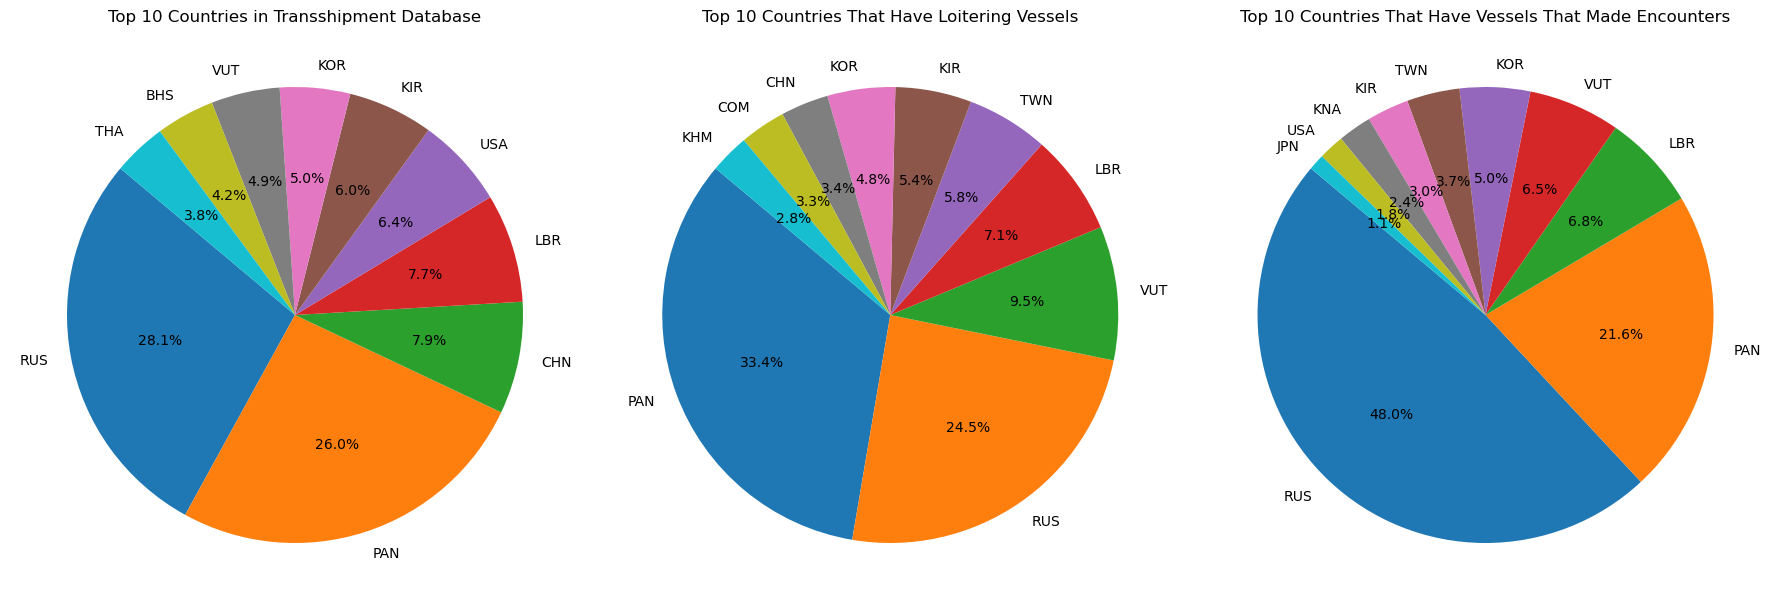

In [29]:
# Set up the matplotlib figure and axes, specifying the figure size
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figure size as needed to fit

# Top 10 countries for Transshipment
transshipment_top10 = transshipments_by_flag.nlargest(10, 'transshipment')
axs[0].pie(transshipment_top10['transshipment'], labels=transshipment_top10['country'], autopct='%1.1f%%', startangle=140)
axs[0].set_title('Top 10 Countries in Transshipment Database')

# Top 10 countries for Loitering
loitering_top10 = transshipments_by_flag.nlargest(10, 'loitering')
axs[1].pie(loitering_top10['loitering'], labels=loitering_top10['country'], autopct='%1.1f%%', startangle=140)
axs[1].set_title('Top 10 Countries That Have Loitering Vessels')

# Top 10 countries for Encounter
encounter_top10 = transshipments_by_flag.nlargest(10, 'encounter')
axs[2].pie(encounter_top10['encounter'], labels=encounter_top10['country'], autopct='%1.1f%%', startangle=140)
axs[2].set_title('Top 10 Countries That Have Vessels That Made Encounters')

plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping
plt.show()


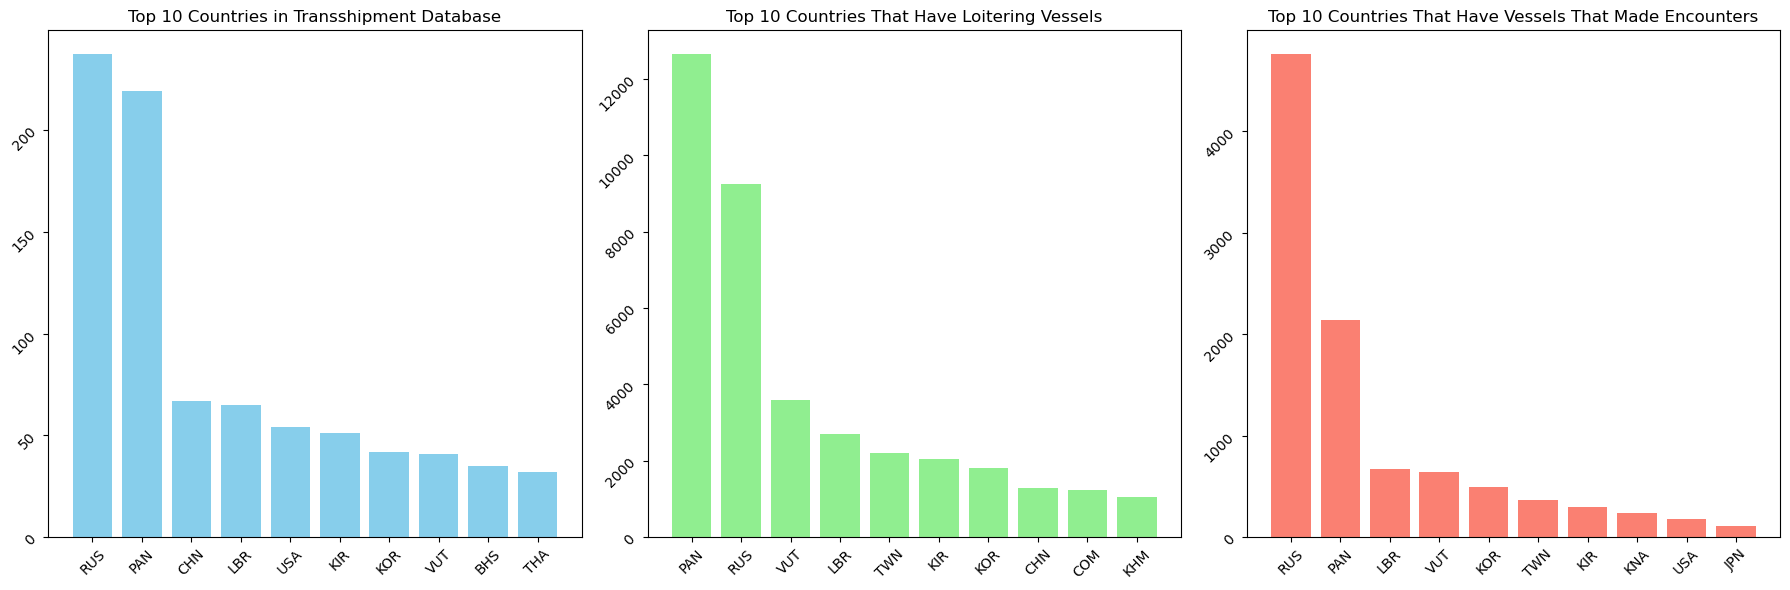

In [30]:
# Data for top 10 countries in each category
transshipment_top10 = transshipments_by_flag.nlargest(10, 'transshipment')
loitering_top10 = transshipments_by_flag.nlargest(10, 'loitering')
encounter_top10 = transshipments_by_flag.nlargest(10, 'encounter')

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figure size as needed

# Top 10 countries for Transshipment
axs[0].bar(transshipment_top10['country'], transshipment_top10['transshipment'], color='skyblue')
axs[0].set_title('Top 10 Countries in Transshipment Database')
axs[0].tick_params(labelrotation=45)  # Rotate labels to improve readability

# Top 10 countries for Loitering
axs[1].bar(loitering_top10['country'], loitering_top10['loitering'], color='lightgreen')
axs[1].set_title('Top 10 Countries That Have Loitering Vessels')
axs[1].tick_params(labelrotation=45)

# Top 10 countries for Encounter
axs[2].bar(encounter_top10['country'], encounter_top10['encounter'], color='salmon')
axs[2].set_title('Top 10 Countries That Have Vessels That Made Encounters')
axs[2].tick_params(labelrotation=45)

plt.tight_layout()  
plt.show()

### 3.2 Unique Vessels in our Dataframes

In [31]:
# Unique Transshipment Vessels
unique_transshipment = transshipment['mmsi'].nunique()
print(f"There are {unique_transshipment} unique transshipment vessels in our database.")

# Unique Loitering Vessels
unique_loitering = loitering['transshipment_mmsi'].nunique()
print(f"There are {unique_loitering} unique loitering vessels in our database.")

# Unique Encounter Vessels
unique_encounter = encounter['transshipment_vessel_mmsi'].nunique()
print(f"There are {unique_encounter} unique encounter vessels in our database.")

There are 1040 unique transshipment vessels in our database.
There are 791 unique loitering vessels in our database.
There are 507 unique encounter vessels in our database.


## 4. Statistical Analysis

### 4.1 Statistical Analysis for Anomaly Detection

In [32]:
# Define a function to identify outliers based on the IQR method
def find_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return data[(data < lower_bound) | (data > upper_bound)]

# Example: Identify outliers in 'duration_hours'
duration_outliers = find_outliers_iqr(matched_encounters['duration_hours'])
print("Number of duration outliers:", len(duration_outliers))


Number of duration outliers: 489


Clustering-Based Anomaly Detection
Clustering algorithms like K-Means can be used to detect anomalies by identifying data points that are not well associated with any cluster.

In [33]:
# Select features for clustering
features = matched_encounters[['mean_latitude', 'mean_longitude', 'duration_hours', 'median_distance_km', 'median_speed_knots']]
features_scaled = StandardScaler().fit_transform(features)

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(features_scaled)
matched_encounters['cluster'] = kmeans.labels_

# Calculate distance of each point to its cluster center
distances = cdist(features_scaled, kmeans.cluster_centers_, 'euclidean')
min_distances = np.min(distances, axis=1)
threshold = np.percentile(min_distances, 95)  # setting threshold as the 95th percentile

# Flag anomalies
matched_encounters['anomaly_cluster'] = min_distances > threshold

Isolation Forest for Anomaly Detection Isolation Forest is an effective algorithm for anomaly detection, especially in datasets with a mix of numerical features

In [34]:
# Initialize and fit the IsolationForest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
matched_encounters['anomaly_iso_forest'] = iso_forest.fit_predict(features_scaled)

# Anomalies are marked as -1
matched_encounters['anomaly_iso_forest'] = matched_encounters['anomaly_iso_forest'] == -1


In [35]:
print("Anomalies detected by Clustering Method:", matched_encounters['anomaly_cluster'].sum())
print("Anomalies detected by Isolation Forest:", matched_encounters['anomaly_iso_forest'].sum())

Anomalies detected by Clustering Method: 316
Anomalies detected by Isolation Forest: 64


In [36]:
# Group data by cluster and calculate mean values for important features
cluster_summary = matched_encounters.groupby('cluster')[['mean_latitude', 'mean_longitude', 'duration_hours', 'median_distance_km', 'median_speed_knots']].mean()
cluster_summary

,mean_latitude,mean_longitude,duration_hours,median_distance_km,median_speed_knots
cluster,,,,,
0,14.648213,49.723590,7.800300,0.270507,1.020632
1,49.383800,145.009160,7.538406,0.041760,0.856314
2,-15.826817,-73.269889,7.384542,0.036914,1.290729
3,-26.255176,-65.395899,8.474989,0.040215,0.522544
4,53.483388,127.358223,35.122860,0.045257,0.752716


In [37]:
# Filter anomalies detected by clustering method
anomalies_clustering = matched_encounters[matched_encounters['anomaly_cluster']]

# Explore characteristics of these anomalies, such as their locations, durations, and speeds
anomalies_clustering[['mean_latitude', 'mean_longitude', 'duration_hours', 'median_distance_km', 'median_speed_knots']].describe().T.style.background_gradient()


,count,mean,std,min,25%,50%,75%,max
mean_latitude,316.000000,32.259127,35.516732,-62.904188,2.493092,48.473999,61.073853,76.594429
mean_longitude,316.000000,22.430509,138.492001,-179.928883,-102.199446,46.046210,150.733824,179.895927
duration_hours,316.000000,23.109177,39.189972,2.000000,3.666667,10.916667,30.833333,527.000000
median_distance_km,316.000000,0.110072,0.103963,0.000000,0.035434,0.061086,0.147158,0.493603
median_speed_knots,316.000000,1.088038,0.648576,0.000000,0.544048,1.122979,1.739314,1.994273


### 4.2 Predict Future Associations Between Vessels

In [38]:
# Create a new graph
G = nx.Graph()

# Assuming 'matched_encounters' DataFrame has 'fishing_vessel_mmsi' and 'transshipment_vessel_mmsi'
for index, row in matched_encounters_copy.iterrows():
    # Add nodes for each vessel if they are not already in the graph
    G.add_node(row['fishing_vessel_mmsi'], type='fishing_vessel')
    G.add_node(row['transshipment_vessel_mmsi'], type='transshipment_vessel')
    
    # Add an edge between the fishing vessel and the transshipment vessel
    G.add_edge(row['fishing_vessel_mmsi'], row['transshipment_vessel_mmsi'])

In [39]:
# Generate all possible non-existent edges (potential future connections)
potential_edges = combinations(G.nodes, 2)

# Filter out edges that already exist in the graph
potential_edges = [edge for edge in potential_edges if not G.has_edge(*edge)]

# Calculate the Jaccard Coefficient for each potential edge
preds = nx.jaccard_coefficient(G, potential_edges)

# Sort potential edges by Jaccard Coefficient, higher means more likely to form a future link
predicted_edges = sorted(preds, key=lambda x: x[2], reverse=True)

# Print top 10 most likely future connections
for u, v, p in predicted_edges[:10]:
    print(f"Vessels {u} & {v} have a Jaccard Coefficient of {p}")

Vessels 576678000 & 576609000 have a Jaccard Coefficient of 1.0
Vessels 306752000 & 355199000 have a Jaccard Coefficient of 1.0
Vessels 306752000 & 311009700 have a Jaccard Coefficient of 1.0
Vessels 412420622 & 412439588 have a Jaccard Coefficient of 1.0
Vessels 412420622 & 412422695 have a Jaccard Coefficient of 1.0
Vessels 412420622 & 412420961 have a Jaccard Coefficient of 1.0
Vessels 412420622 & 412421008 have a Jaccard Coefficient of 1.0
Vessels 412420622 & 412421018 have a Jaccard Coefficient of 1.0
Vessels 412439588 & 412422695 have a Jaccard Coefficient of 1.0
Vessels 412439588 & 412420961 have a Jaccard Coefficient of 1.0


## 5. Machine Learning Analysis

### 5.1 Predict If A Vessel Will Be Located Within A Country's Maritime Boundry (EEZ)

In [40]:
# Selecting features - excluding identifiers and target variable
features = ['mean_latitude', 'mean_longitude', 'duration_hr', 'median_distance_km', 
            'median_speed_knots', 'is_night_time', 'duration_hours', 'abnormal_duration']

X = encounters_gdf[features]
y = encounters_gdf['inside_eez']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
predictions = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.897070467141726
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       410
           1       0.92      0.92      0.92       853

    accuracy                           0.90      1263
   macro avg       0.88      0.88      0.88      1263
weighted avg       0.90      0.90      0.90      1263



### Model Performance Overview

- **Overall Accuracy**: The model accurately predicts whether a vessel is inside or outside EEZ boundaries 91.37% of the time, which is a strong performance for this type of classification task.

- **Class 0 (Outside EEZ)**:
    - **Precision**: 0.87 indicates that when the model predicts a vessel is outside the EEZ, it is correct 87% of the time.
    - **Recall**: 0.85 suggests that the model successfully identifies 85% of all actual cases of vessels being outside the EEZ.
    - **F1-Score**: 0.86 is a measure of the test's accuracy. This score considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

- **Class 1 (Inside EEZ)**:
    - **Precision**: 0.93 shows that when the model predicts a vessel is inside the EEZ, it is correct 93% of the time.
    - **Recall**: 0.94 indicates that the model successfully identifies 94% of all actual cases of vessels being inside the EEZ.
    - **F1-Score**: 0.94 reflects high precision and recall, suggesting the model is highly accurate in identifying vessels within EEZ boundaries.

### 5.2 Time Series Analysis And Forecast Vessel Movements Using LSTM

In [42]:
# Select and normalize the feature
data = matched_encounters[['start_time', 'mean_latitude']].set_index('start_time')

scaler =  MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

In [43]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

In [44]:
# Assuming data_scaled is correctly shaped, we proceed to create sequences
n_steps = 10  # Number of timesteps per sequence
X, y = create_sequences(data_scaled, n_steps)

In [45]:
# Split data into training and testing sets
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [46]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [47]:
# Fit the model
model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)


Epoch 1/100


2024-05-24 15:58:59.657771: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


126/126 [==============================] - 1s 2ms/step - loss: 0.0649 - val_loss: 0.0272
Epoch 2/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0255
Epoch 3/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0224
Epoch 4/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0216
Epoch 5/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0213
Epoch 6/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0207
Epoch 7/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0207
Epoch 8/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0203
Epoch 9/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0218
Epoch 10/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0203
E

126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0197
Epoch 82/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0196
Epoch 83/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0197
Epoch 84/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0197
Epoch 85/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0196
Epoch 86/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0197
Epoch 87/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0195
Epoch 88/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0199
Epoch 89/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0196
Epoch 90/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 

In [48]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

40/40 [==============================] - 0s 752us/step


In [49]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'Test RMSE: {rmse}')

Test RMSE: 24.487676226841966


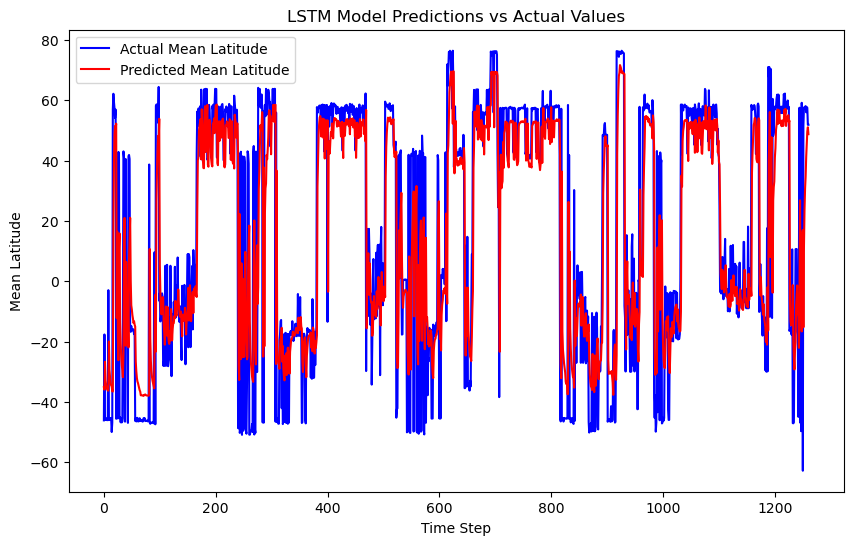

In [50]:
# Plot the actual mean latitude and Predicted Latitude

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual Mean Latitude', color='blue')
plt.plot(predictions_inverse, label='Predicted Mean Latitude', color='red')
plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Mean Latitude')
plt.legend()
plt.show()

### 5.3 Natural Language Processing (NLP) on Ship Names

Given the variability in ship naming conventions, NLP techniques can be applied to normalize ship names and potentially identify when the same vessel is listed under different names, aiding in tracking vessels' histories more accurately

In [51]:
# Fill missing ship names with a placeholder (e.g., "unknown")
merged_matched_encounters_and_transshipment['shipname'].fillna('unknown', inplace=True)

# Basic text cleaning
merged_matched_encounters_and_transshipment['shipname_clean'] = merged_matched_encounters_and_transshipment['shipname'].str.lower().str.replace('[^\w\s]', '', regex=True)


Use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the ship names into a matrix of TF-IDF features.

In [52]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform ship names
tfidf_matrix = vectorizer.fit_transform(merged_matched_encounters_and_transshipment['shipname_clean'])

# tfidf_matrix now represents ship names as numerical data

Compute similarities between ship names using the cosine similarity of their TF-IDF vectors. This can help identify ships with similar names, which might indicate related vessels or common naming patterns among certain groups of ships.

In [53]:
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Now, cosine_sim[i][j] represents the similarity between ship i and ship j


You can cluster ship names based on their TF-IDF feature similarities to identify groups of similarly named ships.

In [54]:
# Number of clusters
n_clusters = 5

# Perform KMeans clustering
km = KMeans(n_clusters=n_clusters, random_state=42)
km.fit(tfidf_matrix)

# Assign the cluster labels to the original dataframe
merged_matched_encounters_and_transshipment['shipname_cluster'] = km.labels_


Examine the clusters to understand naming patterns or associations. This might involve looking at the most common words in each cluster or analyzing the characteristics of ships within the same cluster.

In [55]:
# Examine clusters
for i in range(n_clusters):
    cluster_shipnames = merged_matched_encounters_and_transshipment.loc[merged_matched_encounters_and_transshipment['shipname_cluster'] == i, 'shipname']
    print(f"Cluster {i}:")
    print(cluster_shipnames.value_counts().head(10))  # Print top 10 most frequent ship names in the cluster
    print("\n")

Cluster 0:
shipname
SEIWA                   113
SHOTA MARU              109
WEI SHUN                106
TAIHO MARU               94
CHITOSE                  84
SARONIC BREEZE           73
KAPITAN PRYAKHA          73
MEITA MARU               73
KOMMUNARY NIKOLAYEVA     72
BALYUZEK                 72
Name: count, dtype: int64


Cluster 1:
shipname
HARIMA 2    115
Name: count, dtype: int64


Cluster 2:
shipname
SHIN HANG      89
MING HANG      62
MING HANG 8    46
QI HANG        42
Name: count, dtype: int64


Cluster 3:
shipname
HAI FENG 688    71
HAI FENG 678    69
HAI FENG 618    54
HAI FENG 698    47
HAI FENG 668    39
HAI FENG 648    37
HAI FENG 658    37
HAI FENG 628    35
HAI FENG 718    25
MING FENG       11
Name: count, dtype: int64


Cluster 4:
shipname
SL BOGO    159
Name: count, dtype: int64




The output from clustering ship names using NLP techniques and KMeans suggests that the algorithm has successfully identified distinct naming patterns or groups among the vessels in your dataset. Each cluster appears to represent a set of ships with common elements in their names or possibly ships that are associated with certain activities, regions, or companies. Here's a brief interpretation of each cluster based on the top ship names:

### Cluster 0:
- **Dominant Pattern**: Japanese names, as indicated by the suffix "Maru," which is commonly used in Japanese ship names. This cluster likely represents a significant portion of Japanese fishing or transshipment vessels.
- **Common Names**: "SHOTA MARU," "TAIHO MARU," "MEITA MARU," indicating a naming convention that combines a personal or place name with "Maru."

### Cluster 1:
- **Dominant Pattern**: This cluster is dominated by a single name, "SL BOGO." This might indicate a specific vessel with a high number of records or a data anomaly.
- **Potential Interpretation**: The repetition of a single ship name might suggest a unique case worth investigating further, particularly if the vessel has many encounters.

### Cluster 2:
- **Dominant Pattern**: A single ship name, "HARIMA 2," dominates this cluster. This could represent a vessel with unique characteristics or a specific operational pattern.
- **Possible Significance**: Like Cluster 1, the prominence of a single name suggests that "HARIMA 2" might have a distinct role or significance in your dataset.

### Cluster 3:
- **Dominant Pattern**: A mix of names, including those with numeric suffixes ("SHINHANG6"), regional references, and potentially company names. This cluster might represent a diverse group of vessels with international or specific operational contexts.
- **Notable Names**: Names like "ATLANTIC HOPE" and "KAPITAN PRYAKHA" indicate a wider geographical spread and operational diversity.

### Cluster 4:
- **Dominant Pattern**: Dominated by "CHITOSE," which might indicate a specific vessel or a series of vessels with similar naming.
- **Interpretation**: The singular dominance of "CHITOSE" could indicate a special operational pattern, similar to Clusters 1 and 2, but more context is needed to understand its significance.

### Next Steps:

- **In-depth Analysis**: Investigate the specific activities, histories, and operational patterns of the vessels in each cluster to uncover why they were grouped together. This could involve looking at their encounter histories, flag states, and known behaviors.
- **Data Validation**: Confirm that the dominance of single names in certain clusters is not due to data duplication or errors. Ensure that the dataset accurately reflects unique encounters.
- **Cross-Reference with Other Data**: Use external sources to gain more insights into the vessels in each cluster, such as fishing registries, maritime databases, and tracking websites. This can help validate assumptions about their operations and associations.
- **Temporal Analysis**: Consider the timing of encounters for vessels in each cluster to identify patterns or changes in behavior over time, which could be indicative of seasonal operations or changes in fishing grounds.

This clustering has provided a foundation for segmenting vessels based on naming patterns, which can serve as a basis for further investigation into their behaviors and potential associations with IUU fishing activities.

## 6. Visualizations

### 6.1 Temporal Relationships

In [56]:
# Assuming 'start_time' is your timestamp column in the 'matched_encounters' DataFrame
matched_encounters['start_time'] = pd.to_datetime(matched_encounters['start_time'])

# Sort encounters by time
matched_encounters.sort_values(by='start_time', inplace=True)

In [57]:
# Frequency analysis over months
encounter_counts = matched_encounters.groupby([pd.Grouper(key='start_time', freq='M'), 'fishing_vessel_mmsi', 'transshipment_vessel_mmsi']).size().reset_index(name='encounter_count')


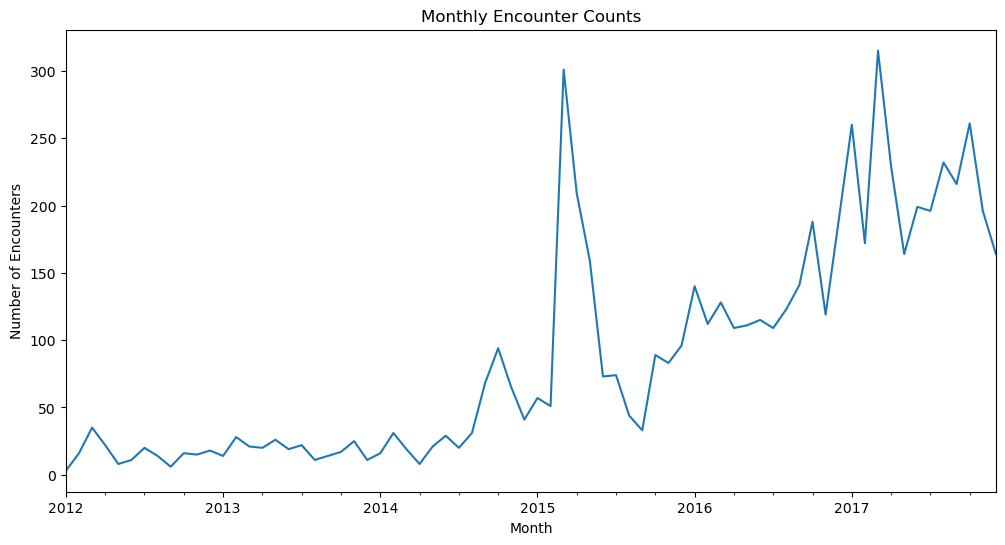

In [58]:
# Sort the data by time
encounter_counts.sort_values('start_time', inplace=True)

# Aggregate encounter counts by time period (e.g., month)
monthly_encounters = encounter_counts.groupby(pd.Grouper(key='start_time', freq='M'))['encounter_count'].sum()

# Plotting
plt.figure(figsize=(12, 6))
monthly_encounters.plot(kind='line')
plt.title('Monthly Encounter Counts')
plt.xlabel('Month')
plt.ylabel('Number of Encounters')
plt.show()

### 6.2 Spatial Relationship - Community Connections

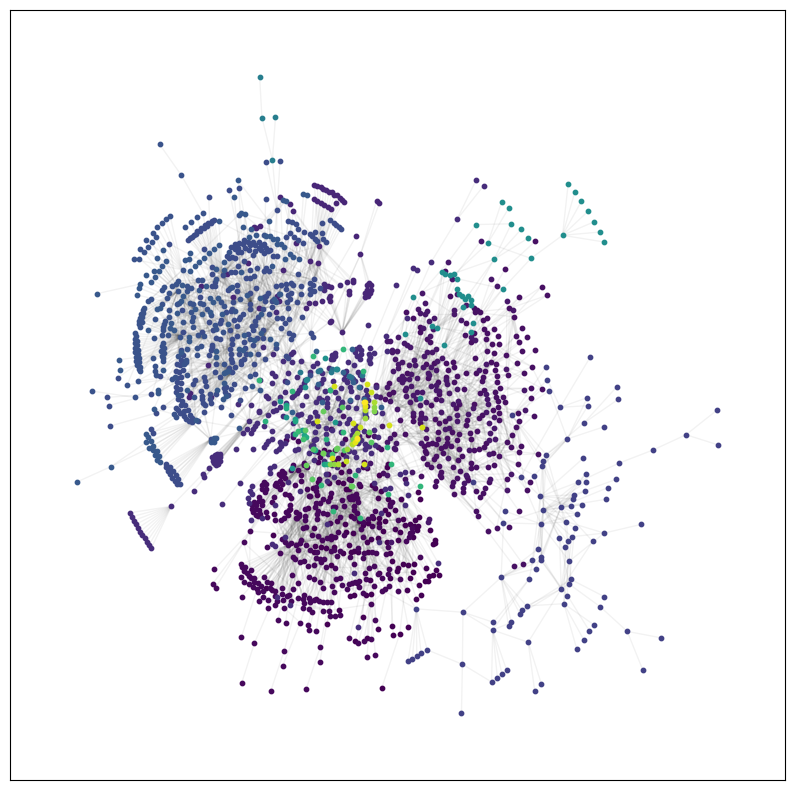

In [59]:
# Visualization with a more informative layout
pos = nx.kamada_kawai_layout(G)

# Assuming G is your graph created from encounters
partition = community_louvain.best_partition(G)

# Assuming 'partition' contains your community info
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
fig, ax = plt.subplots(figsize=(10, 10))

for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=10,
                           node_color=[cmap(com)], label=com, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.05, ax=ax)

# Create a legend for the communities
#legend_handles = [mpatches.Patch(color=cmap(i), label=f'Community {i}') for i in range(max(partition.values()) + 1)]
#plt.legend(handles=legend_handles, title="Communities")

plt.show()

### 6.3 Global Vessel Locations with Loitering Vessels and Vessel Encounters

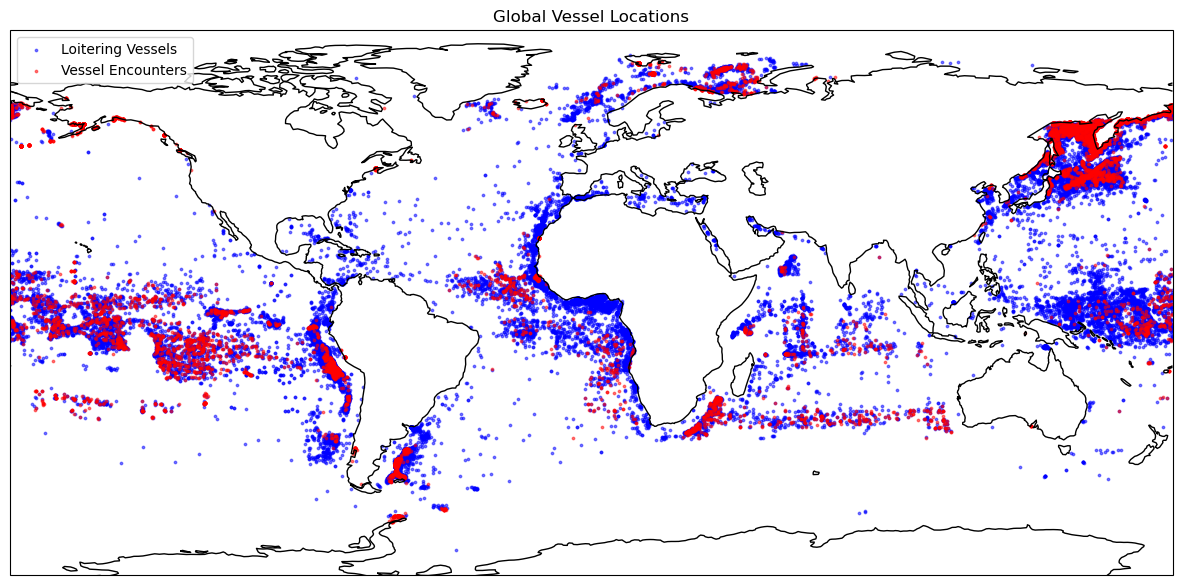

In [60]:
# World map showing locations of loitering events and encounter events
df_loiter = merged_loitering_and_transshipment
df_encounter = merged_encounter_and_transshipment

# Initialize the plot with a specific projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_facecolor('lightblue')  # Make the ocean blue
ax.coastlines()  # Add coastlines to the map

# Plot the first dataset (Loitering and Transshipment)
ax.scatter(df_loiter['starting_longitude'], df_loiter['starting_latitude'], s=3, color='blue', alpha=0.5, transform=ccrs.Geodetic(), label='Loitering Vessels')

# Plot the second dataset (Encounters and Transshipment)
ax.scatter(df_encounter['mean_longitude'], df_encounter['mean_latitude'], s=3, color='red', alpha=0.5, transform=ccrs.Geodetic(), label='Vessel Encounters')

# Add a legend
plt.legend()

# Set a global extent or zoom into a specific region
# ax.set_global()
# Or for a specific region: ax.set_extent([min_lon, max_lon, min_lat, max_lat])

plt.title('Global Vessel Locations')
plt.show()

### 6.4 Global Vessels and Position Relative to Countries Maritime Boundries

In [61]:
# Convert encounter locations to a GeoDataFrame
gdf_encounters = gpd.GeoDataFrame(
    merged_matched_encounters_and_transshipment,
    geometry=[Point(xy) for xy in zip(merged_matched_encounters_and_transshipment['mean_longitude'], merged_matched_encounters_and_transshipment['mean_latitude'])],
    crs="EPSG:4326"  # Ensure the coordinate reference system matches that of your shapefile
)

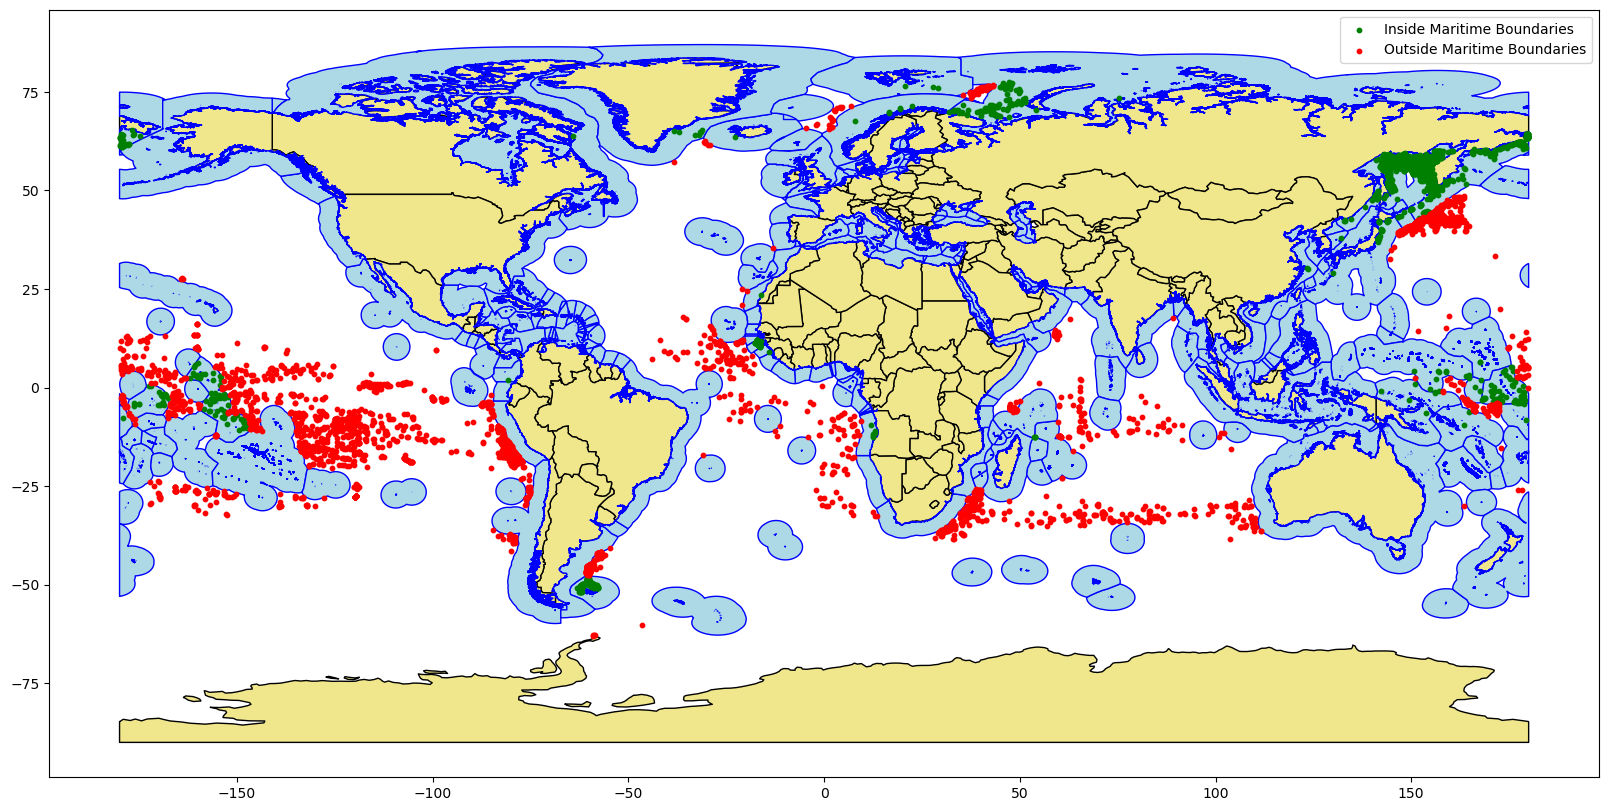

In [62]:
# Load the maritime boundaries shapefile
maritime_boundaries = gpd.read_file('/Users/adamrivardwalter/Data for Processing/Preprocessing/Fisheries Project/World maritime boundries/eez_v12.shp')

# Load the built-in world dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map as a base (to represent land)
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(ax=ax, color='khaki', edgecolor='black')  # color the land in khaki

# Plot maritime boundaries
maritime_boundaries.plot(ax=ax, color='lightblue', edgecolor='blue')


# Perform a spatial join between encounters and maritime boundaries
encounters_within_boundaries = gpd.sjoin(gdf_encounters, maritime_boundaries, how='left', op='within')

# Mark encounters as 'inside' or 'outside'
encounters_within_boundaries['location'] = encounters_within_boundaries['index_right'].apply(lambda x: 'inside' if x >= 0 else 'outside')

# Overlay encounter locations
encounters_within_boundaries[encounters_within_boundaries['location'] == 'inside'].plot(ax=ax, color='green', markersize=10, label='Inside Maritime Boundaries')
encounters_within_boundaries[encounters_within_boundaries['location'] == 'outside'].plot(ax=ax, color='red', markersize=10, label='Outside Maritime Boundaries')

plt.legend()
plt.show()


### 6.5 Heat Map of Vessels within Country's Maritime Boundries

In [63]:
# Define the initial location for the map 
initial_location = [inside_eez_encounters['mean_latitude'].mean(), inside_eez_encounters['mean_longitude'].mean()]

# Create a map object
m = folium.Map(location=initial_location, zoom_start=2)

# Generate a list of lat-long pairs
heat_data = [[row['mean_latitude'], row['mean_longitude']] for index, row in inside_eez_encounters.iterrows()]

# Add a heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Define the HTML content for the title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Heat Map of Vessels Within Country's Maritime Boundries</b></h3>
             '''

# Add the title to the map using a Html object and add it to a Marker, which is then added to the map
m.get_root().html.add_child(folium.Element(title_html))

# Save the map to an HTML file
m.save('/Users/adamrivardwalter/Data Science/Machine Learning/ML Projects/Fisheries Project/heat_map.html')    
    
# Display the map
m


### Fisheries Project Heat Map
[View the map here](https://adamw80.github.io/Fisheries-Project/Folium%20Images/heat_map.html).

<iframe src="https://adamw80.github.io/Fisheries-Project/Folium%20Images/heat_map.html" width="100%" height="600"></iframe>


## 7. Final Analysis

This project has demonstrated the potential of data science and machine learning in combatting illegal fishing activities. By analyzing vessel behavior, identifying hotspots of illegal fishing, and predicting future encounters, we've gained insights into the operational patterns of these illicit operations. The analysis revealed key countries involved in illegal fishing and highlighted the critical regions where enforcement efforts should be concentrated. Furthermore, our machine learning models offer promising tools for predicting vessels' proximity to EEZs and forecasting their movements, providing valuable intelligence for monitoring and enforcement agencies. Moving forward, enhancing our models' accuracy and incorporating real-time data could significantly bolster the fight against illegal fishing, ensuring the sustainability of marine resources for future generations.

## 8. Further Research

#### Areas to further research would be:
- Investigate the economic impact of illegal fishing more comprehensively by estimating the value of illegally caught fish.
- Explore machine learning models that can predict significant changes in vessel behavior, potentially indicating shifts in fishing grounds or methods.
- Examine international collaborations in illegal fishing activities to understand the global network and develop strategies for international cooperation in enforcement efforts.


## 9. References and Rescources

Fishing and Vessel Databases: https://globalfishingwatch.org

EEZ Boundry Map: https://www.marineregions.org